# Tutorial on Online Learning of Actions from Event Camera Streams

This tutorial introduces you to:
- Event-based action recognition dataset THU-EACT-50
- Pretraining pipeline for SNN feature extractor
- Evaluation of the feature extractor for new action classes
- Online Learning of new action classes with CLP

![Tutorial](img/approach.png)

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as display
from IPython.display import Image
from matplotlib import animation
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier, NearestCentroid
from sklearn import metrics
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import pandas as pd

# Dataset THU-EACT-50

Contribution from : 

> Y. Gao et al., "Action Recognition and Benchmark Using Event Cameras," in IEEE Transactions on Pattern Analysis and Machine Intelligence, vol. 45, no. 12, pp. 14081-14097, Dec. 2023. 

The dataset class follows standard torch dataset definition. They are defined in `thu_eact_50.py`. We will just import the dataset here. 

Important facts:

- 50 event-specific action categories
- 105 socially recruited subjects
- 10,500 video recordings
- CeleX-V event camera with a spatial resolution of 1280x800
- Two oblique front views of the actor


![Dataset](img/list_of_actions.png)

In [2]:
from datasets.thu_eact_50 import THU_EACT_50

In [3]:
# bin time 2ms
sampling_time = 2
# sample length 1000ms
sample_length = 1000
# downsampling factor 6 (600x600 -> 100x100)
ds_factor = 6 
# event count representation
repr = ['myCount']
# enable/disable augmentation
aug = False

In [4]:
data_directory = "example_data/"

In [5]:
training_set = THU_EACT_50(path=data_directory, mode="front", train=True, augmentation=aug, repr=repr,
                           sampling_time=sampling_time, sample_length=sample_length, ds_factor=ds_factor, 
                           center_crop=True)

In [6]:
testing_set = THU_EACT_50(path=data_directory, mode="front", train=False, augmentation=False, repr=repr,
                          sampling_time=sampling_time, sample_length=sample_length, ds_factor=ds_factor, 
                          center_crop=True)

Let's visualize the data

In [7]:
from utils.io import tensor_to_event

In [8]:
for i in range(4):
    spike_tensor, label = testing_set[i]
    spike_tensor = spike_tensor.reshape(2, int(600/ds_factor), int(600/ds_factor), -1)
    event = tensor_to_event(spike_tensor.cpu().data.numpy())
    event.t = event.t * sampling_time 
    anim = event.anim(plt.figure(figsize=(5, 5)), frame_rate=20)
    anim.save(f'gifs/test_thu_eact_{i}.gif', animation.PillowWriter(fps=20), dpi=300)
    print("Sample: ", i, "Label: ", label)

Sample:  0 Label:  20
Sample:  1 Label:  12
Sample:  2 Label:  23
Sample:  3 Label:  21


In [9]:
gif_td = lambda gif: f'<td> <img src="{gif}" alt="Drawing" style="height: 250px;"/> </td>'

In [10]:
header = '<table><tr>'
images = ' '.join([gif_td(f'gifs/thu_eact_{i}.gif') for i in range(4)])
footer = '</tr></table>'
display.HTML(header + images + footer)

,,,


# SNN Feature Extractor



Now, we set up the SNN feature extractor

In [11]:
from models.plif_models import AllConvPLIFSNN, AllConvPLIFLISNN

In [12]:
device = torch.device('cpu')
#device = torch.device('cuda')

# model hyperparams
inp_features = 2
channels = 8
feat_neur = 512
classes = 25
dropout = 0.1
pretrain = True

In [13]:
net = AllConvPLIFSNN(inp_features, channels, feat_neur, classes, 
                     delay=False, dropout=dropout, quantize=False, 
                     pretrain=pretrain, device=device).to(device)

In [14]:
net

AllConvPLIFSNN(
  (feature_extractor): ModuleList(
    (0): Conv2d(2, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False, step_mode=m)
    (1): BatchNorm2d(8, eps=0.001, momentum=0.01, affine=True, track_running_stats=True, step_mode=m)
    (2): ParametricLIFNode(
      v_threshold=1.0, v_reset=0.0, detach_reset=True, step_mode=m, backend=torch, tau=2.0
      (surrogate_function): ATan(alpha=2.0, spiking=True)
    )
    (3): Dropout(p=0.1)
    (4): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False, step_mode=m)
    (5): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True, step_mode=m)
    (6): ParametricLIFNode(
      v_threshold=1.0, v_reset=0.0, detach_reset=True, step_mode=m, backend=torch, tau=2.0
      (surrogate_function): ATan(alpha=2.0, spiking=True)
    )
    (7): Dropout(p=0.1)
    (8): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False, step_mode=m)
    (9): BatchNorm2d(32, eps=0.00

# Feature Extractor Training

The next step is the training of the SNN feature extractor on the selected dataset split.
This takes a few hours. Hence, we prepared trained models and also saved features for known and unkown action classes.

Next cell is only there to exemplify the pretraining loop.

In [ ]:
# just for explanation, this code snippet does not run
epochs = 100
for epoch in range(epochs):
    for i, (inp, label) in enumerate(train_loader):  # training loop
        output = assistant.train(inp, label)

    for i, (inp, label) in enumerate(test_loader):  # testing loop
        output = assistant.test(inp, label)

# Feature Extractor Evaluation

Here we select one of the prepared SNN feature extractors and evaluate the quality of its features.

There are three available:
- Pretrained_thu_eact_50_scnn_ds6_plif_38actions_myCnt_aug_2ms
- Pretrained_thu_eact_50_scnn_ds6_plif_25actions_myCnt_aug_2ms
- Pretrained_thu_eact_50_scnn_ds6_plif_li_25actions_myCnt_aug_2ms

In [15]:
folder = 'trained/Pretrained_thu_eact_50_scnn_ds6_plif_38actions_myCnt_aug_2ms/'

In [16]:
with open(folder + 'features_known_train_full.npy', 'rb') as f:
    X_k_train = np.load(f)
    y_k_train = np.load(f)

with open(folder + 'features_known_test_full.npy', 'rb') as f:
    X_k_test = np.load(f)
    y_k_test = np.load(f)

with open(folder + 'features_unknown_train_full.npy', 'rb') as f:
    X_u_train = np.load(f)
    y_u_train = np.load(f)

with open(folder + 'features_unknown_test_full.npy', 'rb') as f:
    X_u_test = np.load(f)
    y_u_test = np.load(f)

### Test for known action classes:

If you want to evaluate for known, pretraining classes, run next cell!

In [25]:
# known actions
unique_labels, counts = np.unique(y_k_train, return_counts=True)
num_classes = len(unique_labels)
X_k_train = X_k_train / np.linalg.norm(X_k_train, axis=1, keepdims=True)
X_k_test = X_k_test / np.linalg.norm(X_k_test, axis=1, keepdims=True)
X_unknown = np.concatenate([X_k_train, X_k_test]) 

n_samples_per_cls = X_unknown.shape[0]/num_classes

n_tr_samples = len(y_k_train) 
n_test_samples = len(y_k_test) 

y_train = y_k_train[:n_tr_samples]
y_test = y_k_test[:n_test_samples]
y_unknown = np.concatenate([y_train, y_test])

### Test for unknown action classes:

If you want to evaluate for unknown, online learning classes, run next cell!

In [64]:
# unknown actions
unique_labels, counts = np.unique(y_u_train, return_counts=True)
num_classes = len(unique_labels)
X_u_train = X_u_train / np.linalg.norm(X_u_train, axis=1, keepdims=True)
X_u_test = X_u_test / np.linalg.norm(X_u_test, axis=1, keepdims=True)
X_unknown = np.concatenate([X_u_train, X_u_test]) 

n_samples_per_cls = X_unknown.shape[0]/num_classes

n_tr_samples = len(y_u_train) 
n_test_samples = len(y_u_test) 

y_train = y_u_train[:n_tr_samples]
y_test = y_u_test[:n_test_samples]
y_unknown = np.concatenate([y_train, y_test])

In [26]:
num_classes

38

In [27]:
X_tsne = TSNE(n_components=2, learning_rate='auto', n_jobs=-1, n_iter_without_progress=600, 
              verbose=2,init='pca', perplexity=n_samples_per_cls, 
              n_iter=1000, metric='cosine', random_state=4).fit_transform(X_unknown)

[t-SNE] Computing 630 nearest neighbors...
[t-SNE] Indexed 7979 samples in 0.004s...
[t-SNE] Computed neighbors for 7979 samples in 6.346s...
[t-SNE] Computed conditional probabilities for sample 1000 / 7979
[t-SNE] Computed conditional probabilities for sample 2000 / 7979
[t-SNE] Computed conditional probabilities for sample 3000 / 7979
[t-SNE] Computed conditional probabilities for sample 4000 / 7979
[t-SNE] Computed conditional probabilities for sample 5000 / 7979
[t-SNE] Computed conditional probabilities for sample 6000 / 7979
[t-SNE] Computed conditional probabilities for sample 7000 / 7979
[t-SNE] Computed conditional probabilities for sample 7979 / 7979
[t-SNE] Mean sigma: 0.053912
[t-SNE] Computed conditional probabilities in 3.631s
[t-SNE] Iteration 50: error = 68.4411545, gradient norm = 0.0061966 (50 iterations in 7.058s)
[t-SNE] Iteration 100: error = 67.7790604, gradient norm = 0.0005429 (50 iterations in 8.562s)
[t-SNE] Iteration 150: error = 67.7156982, gradient norm = 

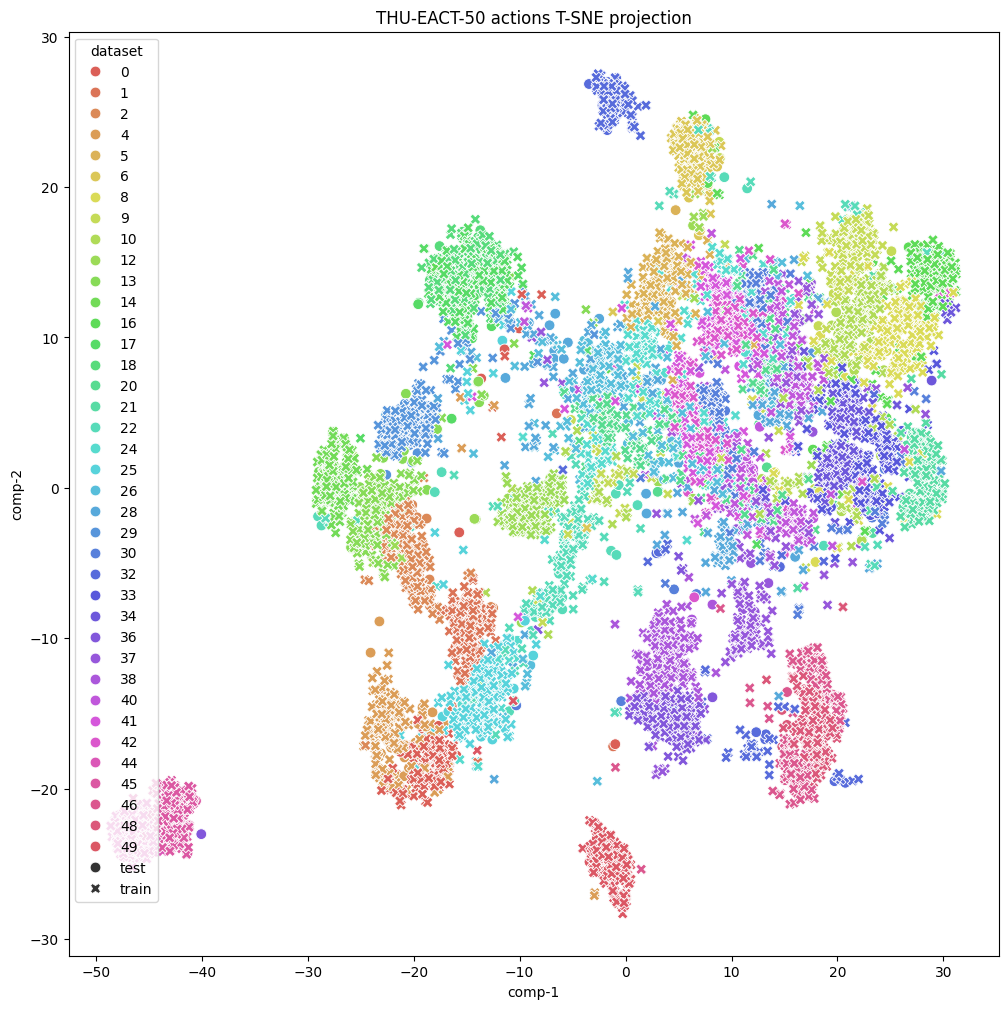

In [28]:
df = pd.DataFrame()
df["y"] = y_unknown
df["comp-1"] = X_tsne[:n_tr_samples+n_test_samples,0]
df["comp-2"] = X_tsne[:n_tr_samples+n_test_samples,1]

df_train = df.iloc[range(len(y_train)), :]
df_train = df_train.iloc[:n_tr_samples]

df_test = df.iloc[range(len(y_train),len(y_unknown)), :]
df_test = df_test.iloc[:n_test_samples]

df_conc = pd.concat([df_test.assign(dataset='test'), df_train.assign(dataset='train')])
# df_train = df_train.iloc[np.argsort(y_u_train),:]
plt.figure(figsize=(12,12))
sns.scatterplot(x="comp-1", y="comp-2", hue=df_conc.y.tolist(), style='dataset', s=60,
                palette=sns.color_palette("hls", num_classes),
                legend=True, data=df_conc).set(title="THU-EACT-50 actions T-SNE projection") #"hls", 
ax=plt.gca()
#plt.savefig(folder + "/tsne_known_proj.png", bbox_inches='tight')

# Static, Offline Classification Tests

![Offline](img/static_adapt_ml.png)

### Test for known action classes:

If you want to evaluate for known, pretraining classes, run next cell!

In [29]:
X_train = X_k_train
y_train = y_k_train
X_test = X_k_test
y_test = y_k_test

### Test for unknown action classes:

If you want to evaluate for unknown, online learning classes, run next cell!

In [40]:
X_train = X_u_train
y_train = y_u_train
X_test = X_u_test
y_test = y_u_test

In [41]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Here, we include some offline classifiers. 
Feel free to checkout [more classifiers](https://scikit-learn.org/stable/supervised_learning.html).

In [42]:
clf = svm.SVC(max_iter=100000, kernel='linear', class_weight='balanced')
clf.fit(X_train_scaled, y_train)
y_pred=clf.predict(X_train_scaled)
print('SVM (Linear)')
print("Training accuracy", np.round(metrics.accuracy_score(y_train, y_pred),2))
y_pred=clf.predict(X_test_scaled)
print("Test accuracy    ", np.round(metrics.accuracy_score(y_test, y_pred),2))
 
print('------------------------------------')
clf = KNeighborsClassifier(n_neighbors=1, n_jobs=8, metric='cosine')
print('KNN (k=1)')
clf.fit(X_train, y_train)
y_pred=clf.predict(X_train)
print("Training accuracy", np.round(metrics.accuracy_score(y_train, y_pred),2))
y_pred=clf.predict(X_test)
print("Test accuracy    ", np.round(metrics.accuracy_score(y_test, y_pred),2))
 
print('------------------------------------')
clf = KNeighborsClassifier(n_neighbors=10, n_jobs=8, metric='cosine')
print('KNN (k=10)')
clf.fit(X_train, y_train)
y_pred=clf.predict(X_train)
print("Training accuracy", np.round(metrics.accuracy_score(y_train, y_pred),2))
y_pred=clf.predict(X_test)
print("Test accuracy    ", np.round(metrics.accuracy_score(y_test, y_pred),2))
 
print('------------------------------------')
clf = NearestCentroid(metric='euclidean')
print('NCM (euclidean)')
clf.fit(X_train, y_train)
y_pred=clf.predict(X_train)
print("Training accuracy", np.round(metrics.accuracy_score(y_train, y_pred),2))
y_pred=clf.predict(X_test)
print("Test accuracy    ", np.round(metrics.accuracy_score(y_test, y_pred),2))

SVM (Linear)
Training accuracy 1.0
Test accuracy     0.94
------------------------------------
KNN (k=1)
Training accuracy 1.0
Test accuracy     0.9
------------------------------------
KNN (k=10)
Training accuracy 0.94
Test accuracy     0.91
------------------------------------
NCM (euclidean)
Training accuracy 0.88
Test accuracy     0.84


# Adaptive, Online CLP Training

Adapted from: 

> Hajizada, Elvin, Balachandran Swaminathan and Yulia Sandamirskaya. “Continual Learning for Autonomous Robots: A Prototype-based Approach.” ArXiv abs/2404.00418 (2024)

Important features:
- From streaming data, online
- Replay-free
- Semi-supervised
- Open set
- Few shot learning

# Continual Learning with Prototypes

![CLP](img/clp.png)

# CLP Algorithm

![CLP](img/clp_algorithm.png)

In [43]:
from utils.torch_clp import ContinuallyLearningPrototypes

In [44]:
clf = ContinuallyLearningPrototypes(
                 input_shape=X_train.shape[1],
                 backbone=None,
                 sim_metric='dot_product',
                 n_protos=500, # maximum number of prototypes
                 num_classes=50,
                 alpha_init=1, # init learning rate
                 sim_th_init=0.8, # similarity threshold
                 device='cpu',
                 supervised=True,
                 adaptive_th=False,
                 adaptive_protos=False, #True,
                 learn_outliers=True,
                 verbose=1
)


In [45]:
X_u_train_normed_t = torch.tensor(X_train)
X_u_test_normed_t = torch.tensor(X_test)
y_train_normed_t = torch.tensor(y_train)
y_test_normed_t = torch.tensor(y_test)

In [46]:
# take all online training samples
train_samples = X_u_train_normed_t.shape[0]
# for few shot learning
#train_samples = 50

In [47]:
for i in range(train_samples):
    clf.fit(X_u_train_normed_t[i], y_train_normed_t[i])

Novel Label!
Novel Label!
Correct winner!
Label tensor(19)
Novel Label!
Novel Label!
Novel Label!
Novel Label!
Novel Label!
Novel Label!
Novel Label!
Wrong winner, allocate novel instance!
Label tensor(23)
Correct winner!
Label tensor(7)
Correct winner!
Label tensor(43)
Novel Label!
Correct winner!
Label tensor(23)
Correct winner!
Label tensor(31)
Correct winner!
Label tensor(23)
Novel Label!
Wrong winner, allocate novel instance!
Label tensor(31)
Wrong winner, allocate novel instance!
Label tensor(43)
Novel Label!
Correct winner!
Label tensor(23)
Correct winner!
Label tensor(23)
Correct winner!
Label tensor(43)
Wrong winner, allocate novel instance!
Label tensor(27)
Correct winner!
Label tensor(31)
Correct winner!
Label tensor(27)
Correct winner!
Label tensor(47)
Correct winner!
Label tensor(7)
Correct winner!
Label tensor(19)
Wrong winner, allocate novel instance!
Label tensor(31)
Wrong winner, allocate novel instance!
Label tensor(11)
Correct winner!
Label tensor(43)
Wrong winner, a

Wrong winner, allocate novel instance!
Label tensor(31)
Correct winner!
Label tensor(39)
Wrong winner, allocate novel instance!
Label tensor(39)
Correct winner!
Label tensor(35)
Correct winner!
Label tensor(11)
Wrong winner, allocate novel instance!
Label tensor(23)
Correct winner!
Label tensor(31)
Correct winner!
Label tensor(47)
Wrong winner, allocate novel instance!
Label tensor(35)
Wrong winner, allocate novel instance!
Label tensor(23)
Wrong winner, allocate novel instance!
Label tensor(35)
Correct winner!
Label tensor(23)
Correct winner!
Label tensor(47)
Correct winner!
Label tensor(39)
Wrong winner, allocate novel instance!
Label tensor(35)
Correct winner!
Label tensor(43)
Correct winner!
Label tensor(3)
Correct winner!
Label tensor(47)
Correct winner!
Label tensor(3)
Correct winner!
Label tensor(19)
Correct winner!
Label tensor(7)
Correct winner!
Label tensor(27)
Correct winner!
Label tensor(7)
Correct winner!
Label tensor(39)
Correct winner!
Label tensor(23)
Correct winner!
La

Label tensor(7)
Wrong winner, allocate novel instance!
Label tensor(39)
Correct winner!
Label tensor(27)
Wrong winner, allocate novel instance!
Label tensor(19)
Correct winner!
Label tensor(47)
Correct winner!
Label tensor(39)
Correct winner!
Label tensor(43)
Correct winner!
Label tensor(43)
Correct winner!
Label tensor(43)
Wrong winner, allocate novel instance!
Label tensor(19)
Wrong winner, allocate novel instance!
Label tensor(3)
Correct winner!
Label tensor(19)
Correct winner!
Label tensor(7)
Correct winner!
Label tensor(3)
Correct winner!
Label tensor(47)
Correct winner!
Label tensor(47)
Correct winner!
Label tensor(11)
Correct winner!
Label tensor(7)
Wrong winner, allocate novel instance!
Label tensor(39)
Correct winner!
Label tensor(15)
Correct winner!
Label tensor(27)
Correct winner!
Label tensor(23)
Correct winner!
Label tensor(7)
Correct winner!
Label tensor(31)
Correct winner!
Label tensor(7)
Wrong winner, allocate novel instance!
Label tensor(27)
Correct winner!
Label tenso

Label tensor(35)
Correct winner!
Label tensor(15)
Correct winner!
Label tensor(47)
Correct winner!
Label tensor(31)
Correct winner!
Label tensor(31)
Correct winner!
Label tensor(23)
Correct winner!
Label tensor(39)
Correct winner!
Label tensor(23)
Correct winner!
Label tensor(47)
Correct winner!
Label tensor(23)
Wrong winner, allocate novel instance!
Label tensor(19)
Correct winner!
Label tensor(39)
Correct winner!
Label tensor(3)
Correct winner!
Label tensor(35)
Wrong winner, allocate novel instance!
Label tensor(19)
Correct winner!
Label tensor(11)
Correct winner!
Label tensor(31)
Correct winner!
Label tensor(15)
Correct winner!
Label tensor(31)
Correct winner!
Label tensor(31)
Correct winner!
Label tensor(43)
Correct winner!
Label tensor(7)
Correct winner!
Label tensor(39)
Correct winner!
Label tensor(11)
Correct winner!
Label tensor(7)
Correct winner!
Label tensor(39)
Wrong winner, allocate novel instance!
Label tensor(39)
Correct winner!
Label tensor(27)
Correct winner!
Label tens

Label tensor(7)
Wrong winner, allocate novel instance!
Label tensor(39)
Wrong winner, allocate novel instance!
Label tensor(19)
Correct winner!
Label tensor(23)
Correct winner!
Label tensor(23)
Correct winner!
Label tensor(11)
Wrong winner, allocate novel instance!
Label tensor(15)
Correct winner!
Label tensor(43)
Correct winner!
Label tensor(15)
Correct winner!
Label tensor(7)
Correct winner!
Label tensor(7)
Correct winner!
Label tensor(3)
Correct winner!
Label tensor(23)
Wrong winner, allocate novel instance!
Label tensor(27)
Correct winner!
Label tensor(31)
Correct winner!
Label tensor(11)
Correct winner!
Label tensor(43)
Correct winner!
Label tensor(11)
Correct winner!
Label tensor(35)
Correct winner!
Label tensor(3)
Correct winner!
Label tensor(31)
Correct winner!
Label tensor(39)
Correct winner!
Label tensor(27)
Correct winner!
Label tensor(11)
Correct winner!
Label tensor(31)
Wrong winner, allocate novel instance!
Label tensor(11)
Correct winner!
Label tensor(3)
Correct winner!


Correct winner!
Label tensor(39)
Wrong winner, allocate novel instance!
Label tensor(23)
Correct winner!
Label tensor(3)
Correct winner!
Label tensor(23)
Correct winner!
Label tensor(35)
Correct winner!
Label tensor(39)
Wrong winner, allocate novel instance!
Label tensor(27)
Correct winner!
Label tensor(23)
Correct winner!
Label tensor(27)
Correct winner!
Label tensor(43)
Wrong winner, allocate novel instance!
Label tensor(35)
Correct winner!
Label tensor(11)
Correct winner!
Label tensor(43)
Wrong winner, allocate novel instance!
Label tensor(11)
Correct winner!
Label tensor(39)
Wrong winner, allocate novel instance!
Label tensor(27)
Correct winner!
Label tensor(7)
Correct winner!
Label tensor(47)
Correct winner!
Label tensor(27)
Correct winner!
Label tensor(7)
Wrong winner, allocate novel instance!
Label tensor(27)
Wrong winner, allocate novel instance!
Label tensor(31)
Correct winner!
Label tensor(39)
Correct winner!
Label tensor(31)
Correct winner!
Label tensor(35)
Correct winner!
L

Label tensor(35)
Correct winner!
Label tensor(7)
Correct winner!
Label tensor(31)
Wrong winner, allocate novel instance!
Label tensor(7)
Wrong winner, allocate novel instance!
Label tensor(15)
Wrong winner, allocate novel instance!
Label tensor(27)
Correct winner!
Label tensor(31)
Correct winner!
Label tensor(47)
Correct winner!
Label tensor(11)
Correct winner!
Label tensor(47)
Correct winner!
Label tensor(31)
Correct winner!
Label tensor(3)
Correct winner!
Label tensor(31)
Correct winner!
Label tensor(19)
Correct winner!
Label tensor(23)
Correct winner!
Label tensor(35)
Correct winner!
Label tensor(23)
Wrong winner, allocate novel instance!
Label tensor(23)
Correct winner!
Label tensor(39)


In [48]:
pred=clf.predict(X_u_train_normed_t, return_probas=False, thresholded=False, return_sims=False)
y_pred = torch.argmax(pred, dim=1)
metrics.accuracy_score(y_train_normed_t.numpy(), y_pred.numpy())

0.961764705882353

In [49]:
y_train_original = y_train_normed_t.numpy() #+ 25 #* 4 + 3
y_pred_original = y_pred.numpy() #+ 25 #* 4 + 3
display_labels = np.unique(y_pred_original)

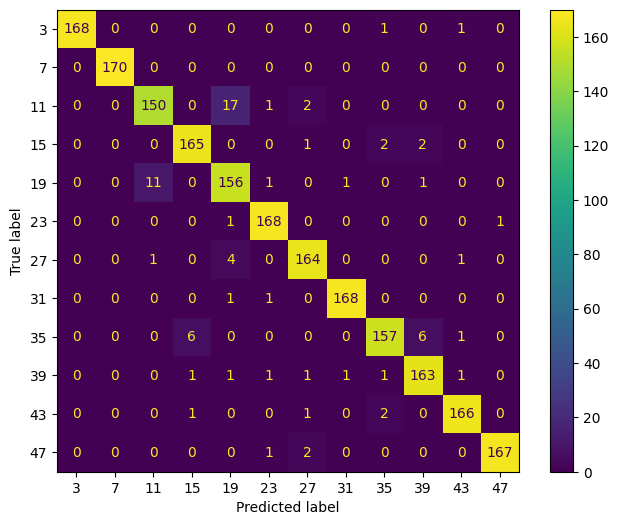

In [50]:
cm = confusion_matrix(y_train_original, y_pred_original)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax)

plt.show()

In [51]:
pred=clf.predict(X_u_test_normed_t, return_probas=False, thresholded=False, return_sims=False)
y_pred = torch.argmax(pred, dim=1)
metrics.accuracy_score(y_test_normed_t.numpy(), y_pred.numpy())

0.85

In [52]:
y_test_original = y_test_normed_t.numpy()
y_pred_original = y_pred.numpy()

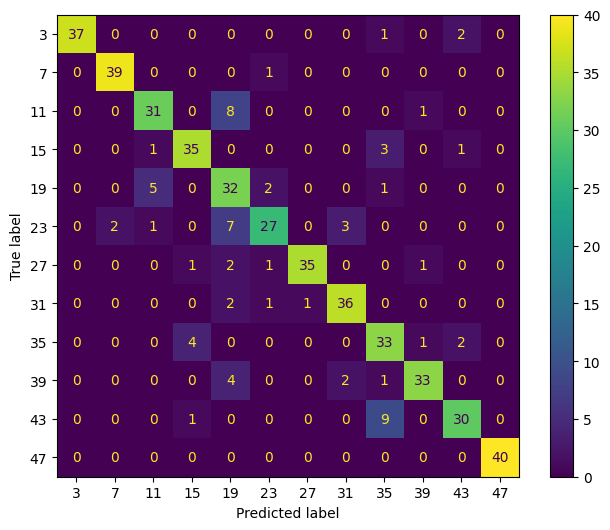

In [53]:
cm = confusion_matrix(y_test_original, y_pred_original)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax)

plt.show()